# Exploring Feature Engineering and Machine Learning Methods

## 1. Introduction
### 1.1. Background and Objective
This report overviews the process of creating a model from the [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic) on Kaggle. This Kaggle competition provides a detailed dataset on the passengers on the infamous Titanic wreck which consist of a training set and a testing set. The model aims to accurately predicting the survivors of the disaster given specific characterizations associated with them.
On April 15th, 1912, the Titanic sank during her maiden voyage and subsequently resulted in the deaths of 68% (1502 / 2224) of the passengers and crew. The dataset provided includes various passengers and crew member's information such as age, sex, passenger class, fare, etc. With this detail, the goal of this challenge is the build a model to predict the survival for a given passenger and to ultimately answer "What type of people survived the sinking of the Titanic?".
### 1.2. Process
1. Research Objective
    - Setup Space and Import Dataset
    - Familiarize with Data columns
    - Initial Overview and Visualization
- Cleaning, Organizing, and Preparing Data
    - Feature Engineering
    - Addressing Missing Data
    - Consider Binning Numerical Data
    - One-Hot Encoding Categorical Data
    - Create Pipeline for Preprocessing
- Model and Predict Dataset
    - Test Various Models
    - Feature Selection
    - Hyperparameter Tuning
    - Conclusion and Exporting Results

### 1.3. Importing Libraries and Dataset

In [1]:
# Importing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

In [2]:
# Reading Data
titanic_data = pd.read_csv('data/train.csv', index_col="PassengerId")
titanic_test = pd.read_csv('data/test.csv', index_col="PassengerId")

# Combine Data
titanic_data['train'] = 1
titanic_test['train'] = 0
fd = pd.concat([titanic_data, titanic_test], sort=True)

## 2. Initial Overview and Visualization
### 2.1. Initial Data Overview
After importing the datafiles provided by Kaggle, it's important to explore the dataset to provide insight on how to organize, adjust, and clean it in order to create an appropriate model to address the objective. The main aspects to extract are the type of data (categorical vs numeric or, continuous vs. independent), columns with missing data, and columns that can pose difficulty to clean. Below, we just observe the data for basic data.

In [3]:
fd.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex',
       'SibSp', 'Survived', 'Ticket', 'train'],
      dtype='object')

In [4]:
fd.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,train
PassengerId,,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,1
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,1
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,1
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,1
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,1


From the data below we get a brief description of the numerical and object data from the dataset. The information shown gives a general overview of the information we're given and insight into how we should organize it. The following are some observations for each column:

**Numerical**
- **Pclass :** Most passengers were in 3rd class (+50% 3rd class, +25% in 2nd class, <25% in 1st class)
- **Age :** Most people on the ship were between 20 - 40 years old (Average age of 30, Range: 0.5 - 80 y.o, 25%  >38 or <20 y.o.)
- **SibSp :** Few passengers had more than one siblings or spouses (<25% had 2+ spouse or siblings)
- **Parch :** Very few passengers had a parent or child on the ride (<25% had 1+ parent or child)
- **Fare :** Most passengers had paid <\\$31 even though the average was \\$32 (Average \\$32, Range \\$0 - \\$512)

**Categorical**
- **Name / Cabin / Ticket :** Large number of unique values, but some commonalities can be extracted
    - **Name :** Should be able to extract prefix of each name
    - **Cabin :** Might be able to see some information in cabin numbers to convert to numerical values
    - **Ticket :** Unsure about these values - looks random, but looking into letter combinations
- **Sex :** Most passengers male (~65% male)
- **Embarked :** Most passengers embarked on Southampton (C = Cherbourg, Q = Queenstown, S = Southampton)


In [5]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 12 columns):
Age         1046 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
Fare        1308 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    891 non-null float64
Ticket      1309 non-null object
train       1309 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [6]:
fd.describe()

,Age,Fare,Parch,Pclass,SibSp,Survived,train
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,891.000000,1309.000000
mean,29.881138,33.295479,0.385027,2.294882,0.498854,0.383838,0.680672
std,14.413493,51.758668,0.865560,0.837836,1.041658,0.486592,0.466394
min,0.170000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,2.000000,0.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,3.000000,0.000000,0.000000,1.000000
75%,39.000000,31.275000,0.000000,3.000000,1.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,3.000000,8.000000,1.000000,1.000000


In [7]:
fd.describe(include=['O'])

,Cabin,Embarked,Name,Sex,Ticket
count,295,1307,1309,1309,1309
unique,186,3,1307,2,929
top,C23 C25 C27,S,"Connolly, Miss. Kate",male,CA. 2343
freq,6,914,2,843,11


From the Kaggle legend for the dataset, we know the type of data for some of the column but having the head of the training set shows some actual columns to help with understanding how it's formatted in practice. To summarize the understanding of the data, a table will be made to simplify the organization and cleaning of the data before modeling. The basic properties I will categorize are:
- **Numerical vs. Categorical -** To differentiate between numerical vs. categorical, numbers vs. letters cannot be the only thing compared. Numerical data contains information on a scale where each value can be compared to each other quantitively. Comparatively, while categorical data can have relative values, the true difference is unknown.
    - **Numerical :** discreet, continuous, timeseries
    - **Categorical :** ordinal, nominal, binary
- **Complete vs. Missing -** Missing values must be dealt with in one of many methods, so should be noted for future organization of the data.
- **Cardinality (if Categorical) -** For categorical values, it may be difficult of input into the model if it has too many cardinalities. Therefore, these columns may be dropped, or manipulation of the columns' data must be performed to lower the cardinality.

|**Name**|Column|Type|Complete|Cardinality|
|-|-|-|-|-|
|**Passenger Class**|Pclass|Catagorical (Ordinal)|Complete|3|
|**Name**|Name|Catagorical (Nominal)|Complete|891|
|**Sex**|Sex|Catagorical (Nominal)|Complete|2|
|**Age in Years**|Age|Numerical (continuous)|Incomplete|n/a|
|**Siblings or Spouses**|SibSp|Numerical (Discrete)|Complete|n/a|
|**Parents or Children**|Parch|Numerical (Discrete)|Complete|n/a|
|**Ticket Number**|Ticket|Catagorical (Nominal)|Complete|681|
|**Passenger Fare**|Fare|Numerical (Continuous)|Complete|n/a|
|**Cabin Number**|Cabin|Catagorical (Nominal)|Incomplete|147|
|**Port Embarked**|Embarked|Catagorical (Nominal)|Incomplete|3|

### 2.2. Initial Visualization
#### 2.2.1. Gender (Sex)
With gender, it's assumed that woman would survive more than men due to gender norms and expectations. Especially at the time given the phrase "woman and children first" which is still referred to this day. As seen in comparing the percent of woman and men that survived, it's clear that woman were greatly favored to survive.

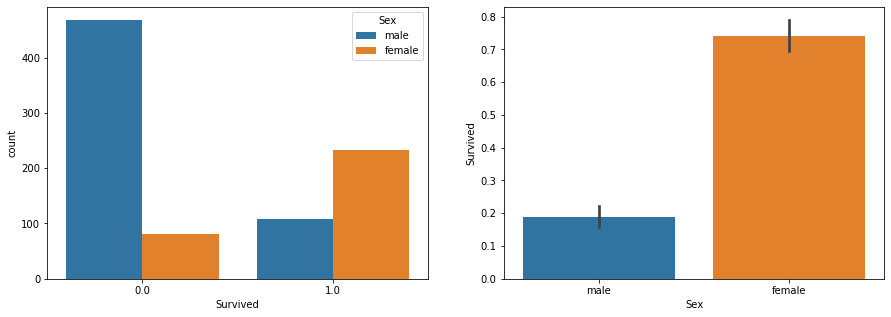

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x="Survived", hue="Sex", data=fd, ax=ax[0])
sns.catplot(x="Sex", y="Survived", data=fd, kind="bar", ax=ax[1])
plt.close(2)

#### 2.2.2. Passenger Class (Pclass)
Knowing the passenger class of each passenger allows a prediction on the passenger's social class. Seeing how passengers in the first class most likely were those who were more privileged, we assume that passengers in first class will have higher survival rates than those and second, while those in second class would have higher survival than those in third class. As seen, this assumption is correct

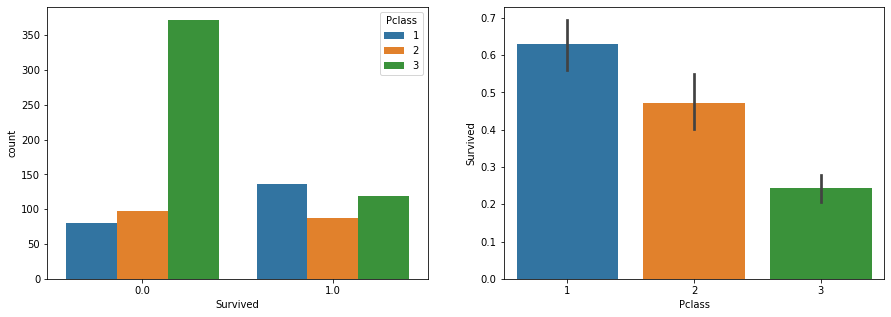

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x="Survived", hue="Pclass", data=fd, ax=ax[0])
sns.catplot(x="Pclass", y="Survived", data=fd, kind="bar", ax=ax[1])
plt.close(2)

#### 2.2.3. Embarked Location (Embarked)
Each embarked location denoted a sperate location. There seems to be more people embarked in location C that survived, so that indicates that for some reason people that embarked from that location were more correlated with survival. Given passenger class, a larger majority of members that boarded in location C were from Passenger Class 1.

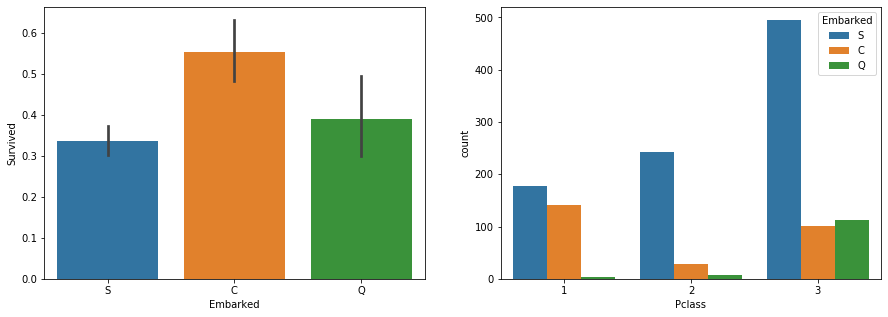

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x="Pclass", hue="Embarked", data=fd, ax=ax[1])
sns.catplot(x="Embarked", y="Survived", data=fd, kind="bar", ax=ax[0])
plt.close(2)

#### 2.2.4. Age Distribution (Age)
Passenger ages seem to be normally distributed and show a mean of around 30 years old. There seems to be a spike at a lower age range which shows that the survival rate of younger passengers are higher.

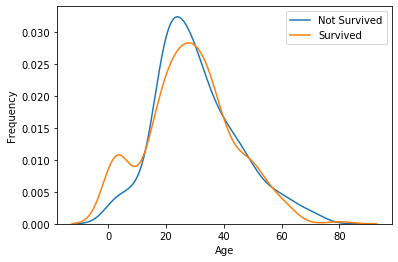

In [11]:
g = sns.kdeplot(fd["Age"][(fd["Survived"] == 0) & (fd["Age"].notnull())])
g = sns.kdeplot(fd["Age"][(fd["Survived"] == 1) & (fd["Age"].notnull())])
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survived"])

#### 2.2.5. Fare Distribution (Fare)
It's seen that passengers at lower fares show a lower survival rates compared to those paying higher fares. This is seen to coincide with the fares that each passenger class is paying, with Pclass 3 and 2 paying the least (below $100) and Pclass 1 seeming to pay more.

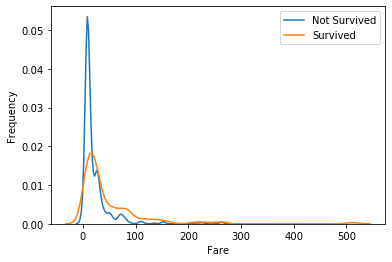

In [12]:
g = sns.kdeplot(fd["Fare"][(fd["Survived"] == 0) & (fd["Fare"].notnull())])
g = sns.kdeplot(fd["Fare"][(fd["Survived"] == 1) & (fd["Fare"].notnull())])
g.set_xlabel("Fare")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survived"])

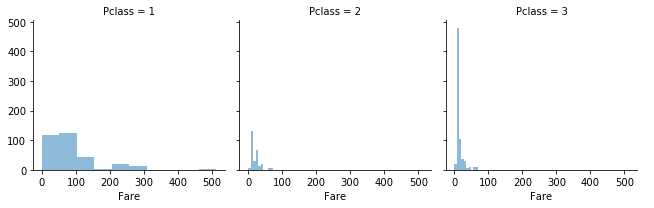

In [13]:
grid = sns.FacetGrid(fd, col='Pclass')
grid.map(plt.hist, 'Fare', alpha=.5, bins=10)
grid = grid.add_legend()

## 3. Feature Engineering
### 3.1 Related Passengers (SibSp & Parch)
When looking at siblings, spouses, parents or children related to a passenger, it is important to see if there's any correlation between the two seeing how these values are related in nature. Therefore, the survival given the number of SibSp or Parch are graphed below.

It's observed that both SibSp and Parch hold similar trends of solo members having a lower survival rate compared to families of two or three which hold higher survival rates. The same trend is seen in combined family sizes, and outlines that large families have low survival rates while families of 2, 3, and 4 are similar in survival rates.

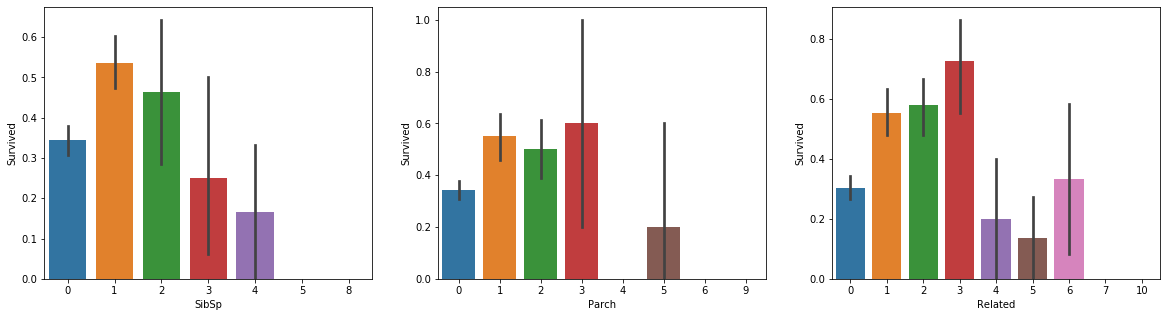

In [14]:
# Test data set with related
related_test = fd.copy()
related_test['Related'] = related_test.SibSp + related_test.Parch

# Plotting Values
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.catplot(x="SibSp", y="Survived", data=related_test, kind="bar", ax=ax[0])
sns.catplot(x="Parch", y="Survived", data=related_test, kind="bar", ax=ax[1])
sns.catplot(x="Related", y="Survived", data=related_test, kind="bar", ax=ax[2])

for i in range(2, 5):
    plt.close(i)

Seeing how total number or related passengers hold similar and more information than the SibSp and Parch, these columns can be condensed and dropped in favor of a Related column. This column can also be segregated into different bins according to size of the family.

This adjustment to the columns is outlined below in the **combined_related** function.

In [15]:
def combine_related(df):
    df['Related'] = df.SibSp + df.Parch
    df['Related'] = df['Related'].map(lambda y: "Solo" if y == 0
                                      else "Duo" if y == 1
                                      else "Trio" if y == 2
                                      else "Quart" if y == 3
                                      else "Large")
    df.drop(['SibSp', 'Parch'], axis=1, inplace=True)
    return df

In [16]:
# New copy sorted for graph below
combine_related_test = fd.copy()
combine_related_test.sort_values(
    by=['SibSp', 'Parch'], ascending=True, inplace=True)

# Testing function
combine_related(combine_related_test)
print(combine_related_test.Related.unique())
combine_related_test.describe(include=['O'])

['Solo' 'Duo' 'Trio' 'Quart' 'Large']


,Cabin,Embarked,Name,Sex,Ticket,Related
count,295,1307,1309,1309,1309,1309
unique,186,3,1307,2,929,5
top,C23 C25 C27,S,"Connolly, Miss. Kate",male,CA. 2343,Solo
freq,6,914,2,843,11,790


In [17]:
pd.crosstab(combine_related_test['Related'], combine_related_test['Survived'])

Survived,0.0,1.0
Related,,
Duo,72,89
Large,52,10
Quart,8,21
Solo,374,163
Trio,43,59


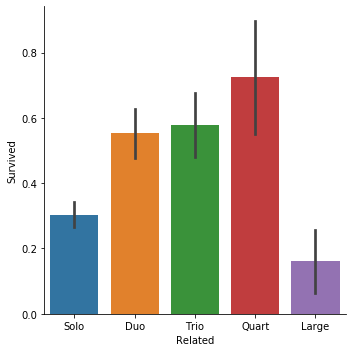

In [18]:
g = sns.catplot(y="Survived", x="Related",
                data=combine_related_test, kind="bar")

### 3.2 Passenger's Title (Name)
All passengers submitted a name which should realistically be all different which makes the information provided all but useless. However, all passengers provided a prefix which is reliably in the middle of their name, before a period. Therefore, it is possible to extract the following title from each passenger.

Seeing how most values are prefixes not used to this day, the values are separated into female and male to understand if it's a feminine or masculine prefix. For other values that are not distinguishable, google was a great help to understand if the title had any greater meaning.

In [19]:
# Test data set extracting title
title_test = fd.copy()
title_test['Title'] = title_test.Name.str.extract(
    ' ([A-Za-z]+)\.', expand=False)

# Observe results
print(title_test.Title.unique())
pd.crosstab(title_test['Title'], title_test['Sex'])

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer' 'Dona']


Sex,female,male
Title,,
Capt,0,1
Col,0,4
Countess,1,0
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2


Seeing the survival rates of each title, it's clear that there's a clear difference between the titles. (1) Female titles (and married > un-married females) have significantly higher survival rates, (2) Masters have higher survival rates than other males, (3) there are other rare titles which mostly are royalty. They can be consolidated into the following subsections:

**High-Ranking (HR)**: 'Master', 'Don', 'Dr', 'Major', 'Col', 'Capt', 'Jonkheer' <br/>
**Married (or HR) Female (MF)**: 'Mrs', 'Mme', 'Countess', 'Dona', 'Lady' <br/>
**Not-Married Female (NF)**: 'Miss', 'Mlle', 'Ms' <br/>
**Male (MA)**: 'Mr', 'Rev', 'Sir'<br/>

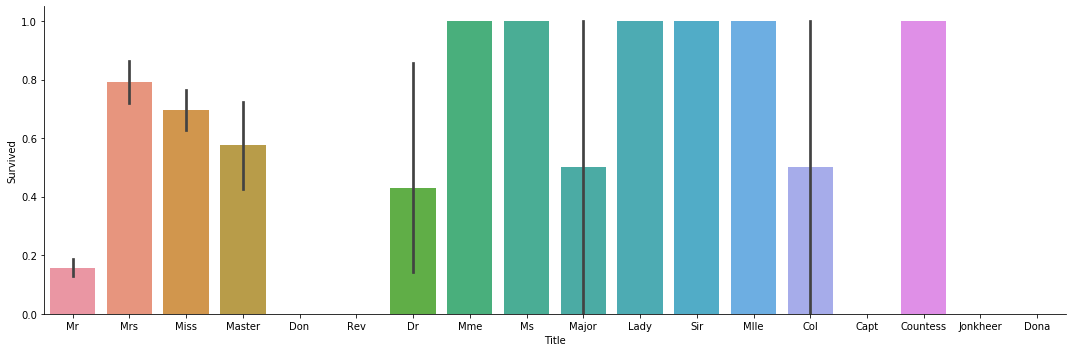

In [20]:
g = sns.catplot(y="Survived", x="Title", data=title_test,
                kind="bar", height=5, aspect=3)

In [21]:
title_test.groupby('Title').agg({'Survived': ['mean', 'count']})

Survived      
              mean count
Title                   
Capt      0.000000     1
Col       0.500000     2
Countess  1.000000     1
Don       0.000000     1
Dona           NaN     0
Dr        0.428571     7
Jonkheer  0.000000     1
Lady      1.000000     1
Major     0.500000     2
Master    0.575000    40
Miss      0.697802   182
Mlle      1.000000     2
Mme       1.000000     1
Mr        0.156673   517
Mrs       0.792000   125
Ms        1.000000     1
Rev       0.000000     6
Sir       1.000000     1

In [22]:
def extract_title(df):
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].map(lambda y: "M" if y in ['Mr', 'Rev', 'Sir']
                                  else "MF" if y in ['Mrs', 'Mme', 'Countess', 'Dona', 'Lady']
                                  else "NF" if y in ['Miss', 'Mlle', 'Ms']
                                  else "H" if y in ['Master', 'Don', 'Dr', 'Major', 'Col', 'Capt', 'Jonkheer']
                                  else y)
    df.drop(['Name'], axis=1, inplace=True)
    return df

In [23]:
# New copy to test function
extract_title_test = fd.copy()
extract_title(extract_title_test)

print(extract_title_test.Title.unique())
extract_title_test.describe(include=['O'])

['M' 'MF' 'NF' 'H']


,Cabin,Embarked,Sex,Ticket,Title
count,295,1307,1309,1309,1309
unique,186,3,2,929,4
top,C23 C25 C27,S,male,CA. 2343,M
freq,6,914,843,11,766


In [24]:
pd.crosstab(extract_title_test['Title'], extract_title_test['Survived'])

Survived,0.0,1.0
Title,,
H,26,28
M,442,82
MF,26,102
NF,55,130


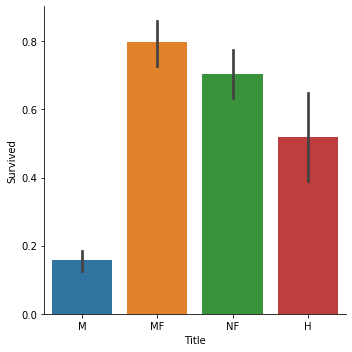

In [25]:
g = sns.catplot(y="Survived", x="Title", data=extract_title_test, kind="bar")

### 3.3. Deck Section (Cabin)
The cabin number provided is an incomplete column, but we can still observe trends within the data. The main value extracted is the letter before the room number which should dictate the deck of the titanic the passenger was staying in. While this set of data isn't as complete as others, there are some small trends within the deck values.

In general it looks like some decks are slightly more safe than others, and therefore were separated out into slightly safer and slightly less safer categories.

[nan 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


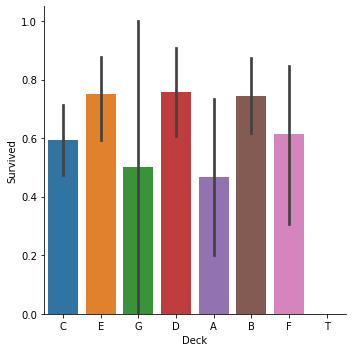

In [26]:
# Test data set extracting Deck
deck_test = fd.copy()
deck_test['Deck'] = deck_test.Cabin.str.extract('([A-Za-z])', expand=False)

# Observe results
print(deck_test.Deck.unique())
g = sns.catplot(y="Survived", x="Deck", data=deck_test, kind="bar")

In [27]:
deck_test.groupby('Deck').agg({'Survived': ['mean', 'count']})

Survived      
          mean count
Deck                
A     0.466667    15
B     0.744681    47
C     0.593220    59
D     0.757576    33
E     0.750000    32
F     0.615385    13
G     0.500000     4
T     0.000000     1

In [28]:
def extract_deck(df):
    df['Deck'] = df.Cabin.str.extract('([A-Za-z])', expand=False)
    df['Deck'] = df['Deck'].map(lambda y: "Safer" if y in ['E', 'D', 'B']
                                else "Less" if y in ['C', 'G', 'A', 'F', 'T']
                                else y)
    df.drop(['Cabin'], axis=1, inplace=True)
    return df

In [29]:
# New copy to test function
extract_deck_test = fd.copy()
extract_deck(extract_deck_test)

print(extract_deck_test.Deck.unique())
extract_deck_test.describe(include=['O'])

[nan 'Less' 'Safer']


,Embarked,Name,Sex,Ticket,Deck
count,1307,1309,1309,1309,295
unique,3,1307,2,929,2
top,S,"Connolly, Miss. Kate",male,CA. 2343,Safer
freq,914,2,843,11,152


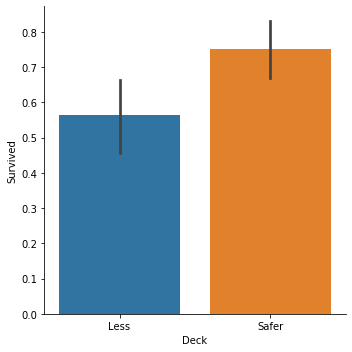

In [30]:
g = sns.catplot(y="Survived", x="Deck", data=extract_deck_test, kind="bar")

### 3.4. Bought Location (Ticket)
Ticket number can be indicative of the location and / or the time in which the ticket was bought. The primary values noted was once again the letters since the numbers were most likely randomly generated and would most likely not contribute to improving the model. Instead with the letters extracted it's observed that certain letters have a higher survival rate and therefore are split accordingly.

['A' 'P' 'S' nan 'C' 'W' 'F' 'L']


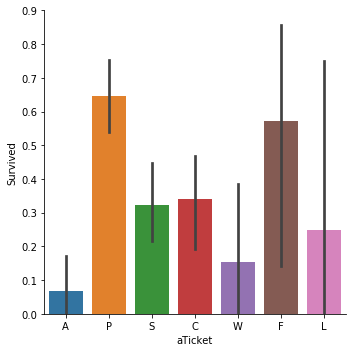

In [31]:
# Test data set extracting Deck
ticket_test = fd.copy()
ticket_test['aTicket'] = deck_test.Ticket.str.extract(
    '([A-Za-z])', expand=False)

# Observe results
print(ticket_test.aTicket.unique())
g = sns.catplot(y="Survived", x="aTicket", data=ticket_test, kind="bar")

In [32]:
ticket_test.groupby('aTicket').agg({'Survived': ['mean', 'count']})

Survived      
             mean count
aTicket                
A        0.068966    29
C        0.340426    47
F        0.571429     7
L        0.250000     4
P        0.646154    65
S        0.323077    65
W        0.153846    13

In [33]:
def extract_ticket(df):
    df['Ticket'] = df.Ticket.str.extract('([A-Za-z])', expand=False)
    df['Ticket'] = df['Ticket'].map(lambda y: "High" if y in ['P', 'F']
                                    else "Mid" if y in ['S', 'C']
                                    else "Low" if y in ['A', 'W', 'L']
                                    else y)
    return df

In [34]:
# New copy to test function
extract_ticket_test = fd.copy()
extract_ticket(extract_ticket_test)

print(extract_ticket_test.Ticket.unique())
extract_ticket_test.describe(include=['O'])

['Low' 'High' 'Mid' nan]


,Cabin,Embarked,Name,Sex,Ticket
count,295,1307,1309,1309,352
unique,186,3,1307,2,3
top,C23 C25 C27,S,"Connolly, Miss. Kate",male,Mid
freq,6,914,2,843,175


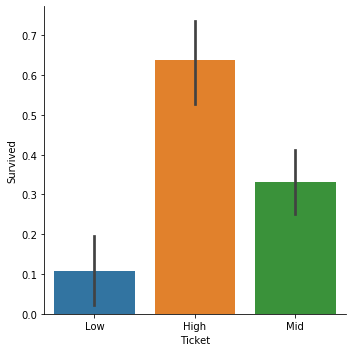

In [35]:
g = sns.catplot(y="Survived", x="Ticket", data=extract_ticket_test, kind="bar")

To see if there's any correlation between the title of the members and the letter on their ticket, the extract_title function was used to be cross examined.

In [36]:
extract_title(extract_ticket_test)
pd.crosstab(extract_ticket_test['Ticket'], extract_ticket_test['Title'])

Title,H,M,MF,NF
Ticket,,,,
High,4,49,31,27
Low,4,47,6,9
Mid,13,111,21,30


### 3.5 Feature Engineering Pipeline
All four functions that addressed the "SibSp, Parch, Name, Cabin, Ticket" columns are combined into a single pipeline "feature_engineering" which will be used to simplify processing the data for the model. The output variables and unique values are dramatically lowered for each and are now fitted better for the model.

In [37]:
def feature_engineering(df):
    (df.pipe(combine_related)
     .pipe(extract_title)
     .pipe(extract_deck)
     .pipe(extract_ticket))
    return df

In [38]:
pipeline_test = fd.copy()
feature_engineering(pipeline_test)

print("Related :", pipeline_test.Related.unique())
print("Title   :", pipeline_test.Title.unique())
print("Deck    :", pipeline_test.Deck.unique())
print("Ticket  :", pipeline_test.Ticket.unique())
pipeline_test.describe(include='all')

Related : ['Duo' 'Solo' 'Large' 'Trio' 'Quart']
Title   : ['M' 'MF' 'NF' 'H']
Deck    : [nan 'Less' 'Safer']
Ticket  : ['Low' 'High' 'Mid' nan]


,Age,Embarked,Fare,Pclass,Sex,Survived,Ticket,train,Related,Title,Deck
count,1046.000000,1307,1308.000000,1309.000000,1309,891.000000,352,1309.000000,1309,1309,295
unique,NaN,3,NaN,NaN,2,NaN,3,NaN,5,4,2
top,NaN,S,NaN,NaN,male,NaN,Mid,NaN,Solo,M,Safer
freq,NaN,914,NaN,NaN,843,NaN,175,NaN,790,766,152
mean,29.881138,NaN,33.295479,2.294882,NaN,0.383838,NaN,0.680672,NaN,NaN,NaN
std,14.413493,NaN,51.758668,0.837836,NaN,0.486592,NaN,0.466394,NaN,NaN,NaN
min,0.170000,NaN,0.000000,1.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN
25%,21.000000,NaN,7.895800,2.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN
50%,28.000000,NaN,14.454200,3.000000,NaN,0.000000,NaN,1.000000,NaN,NaN,NaN
75%,39.000000,NaN,31.275000,3.000000,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN


## 4. Missing data
### 4.1. Classifying Missing Columns
It can be beneficial to point out which columns and specifically which rows contain missing values that we are going to fill. These include Age, Cabin numbers, Embarked location, Ticket number with letter, and Fare paid. Therefore, in the model, it will also include a column for each of these values that show which values were in the original data set, False, and values that are imputed are marked as True in the "_was_missing" columns.

To test this function, the "pineline_test" dataframe with the adjusted features was used to get an accurate indication.

In [39]:
def missing_col(df):
    cols_with_missing = [col for col in df.columns if df[col].isnull().any()]
    cols_with_missing.remove('Survived')
    for col in cols_with_missing:
        df[col + '_was_missing'] = df[col].isnull()
    return df

In [40]:
# New copy to test function with pipeline
missing_col_test = pipeline_test.copy()
missing_col(missing_col_test)

missing_col_test.head()

,Age,Embarked,Fare,Pclass,Sex,Survived,Ticket,train,Related,Title,Deck,Age_was_missing,Embarked_was_missing,Fare_was_missing,Ticket_was_missing,Deck_was_missing
PassengerId,,,,,,,,,,,,,,,,
1,22.0,S,7.2500,3,male,0.0,Low,1,Duo,M,NaN,False,False,False,False,True
2,38.0,C,71.2833,1,female,1.0,High,1,Duo,MF,Less,False,False,False,False,False
3,26.0,S,7.9250,3,female,1.0,Mid,1,Solo,NF,NaN,False,False,False,False,True
4,35.0,S,53.1000,1,female,1.0,NaN,1,Duo,MF,Less,False,False,False,True,False
5,35.0,S,8.0500,3,male,0.0,NaN,1,Solo,M,NaN,False,False,False,True,True


### 4.2. Simple Imputer (Categorical and Numerical Data)
After adding which columns and rows contained missing values, next is to fill the missing data. While it can be convenient to drop columns or rows with missing columns, it can be potentially damaging to the model. Therefore, it is advised to impute a value into these spots whether it be a constant variable, median, or the mode.

To simplify the imputation of each column, the median of numerical columns and the mode of the categorical columns were used (unless there are >10% missing data in which a constant "N" is used). Also, since age had a large portion that wasn't filled but not over %20, it was decided that age will be filled according to median age using specified factors.

#### 4.2.1. Age Prediction
Given the age of each of the passengers, various factors were explored to determine the optimal variable to group each age group into and to subsequently fill in by the median age from the grouped variables.

As seen in the box and whisker graphs, Deck, Sex, Embarked, and Related show minimal relationship to age. Comparatively, Pclass and Title show separation in the quadrants between the Title and Pclass ages.

In [41]:
age_fill_test = titanic_data.copy()
age_fill_test = extract_title(age_fill_test)

grouped_train = age_fill_test.groupby(['Sex', 'Pclass', 'Title'])
grouped_median_train = grouped_train.median()

grouped_median_train

Survived   Age  SibSp  Parch      Fare  train
Sex    Pclass Title                                               
female 1      H           1.0  49.0    0.0    0.0  25.92920    1.0
              MF          1.0  40.0    1.0    0.0  79.20000    1.0
              NF          1.0  30.0    0.0    0.0  88.25000    1.0
       2      MF          1.0  32.0    1.0    0.0  26.00000    1.0
              NF          1.0  24.0    0.0    0.0  13.00000    1.0
       3      MF          0.5  31.0    1.0    1.0  15.97500    1.0
              NF          0.5  18.0    0.0    0.0   8.75625    1.0
male   1      H           0.5  44.0    0.0    0.0  37.55000    1.0
              M           0.0  40.0    0.0    0.0  44.75000    1.0
       2      H           1.0   2.0    1.0    1.0  26.00000    1.0
              M           0.0  31.0    0.0    0.0  13.00000    1.0
       3      H           0.0   4.0    3.5    1.0  28.51250    1.0
              M           0.0  26.0    0.0    0.0   7.89580    1.0

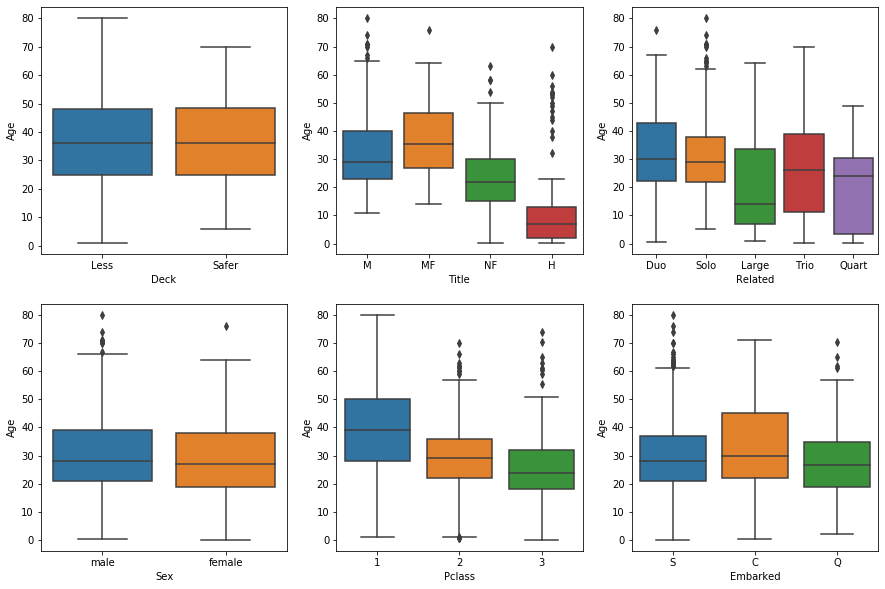

In [42]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

sns.boxplot(data=pipeline_test, x="Deck", y="Age", ax=ax[0, 0])
sns.boxplot(data=pipeline_test, x="Title", y="Age", ax=ax[0, 1])
sns.boxplot(data=pipeline_test, x="Related", y="Age", ax=ax[0, 2])
sns.boxplot(data=pipeline_test, x="Sex", y="Age", ax=ax[1, 0])
sns.boxplot(data=pipeline_test, x="Pclass", y="Age", ax=ax[1, 1])
sns.boxplot(data=pipeline_test, x="Embarked", y="Age", ax=ax[1, 2])

#### 4.2.2. Simple Imputer

In [43]:
print("Embarked_mode :", pipeline_test.Embarked.mode()[0])
print("Ticket_mode   :", pipeline_test.Ticket.mode()[0])
print("Deck_mode     :", pipeline_test.Deck.mode()[0])
print("Fare_median   :", pipeline_test.Fare.median())

Embarked_mode : S
Ticket_mode   : Mid
Deck_mode     : Safer
Fare_median   : 14.4542


In [44]:
def simple_imputer(df):
    # catagorical columns - Mode
    cat_col = [col for col in df.columns if df[col].dtype == 'object']
    cat_col.remove('Ticket')
    cat_col.remove('Deck')
    cat_imputer = SimpleImputer(strategy='most_frequent')
    cat_imputer.fit(df[cat_col])
    df[cat_col] = cat_imputer.fit_transform(df[cat_col])

    # catagorical columns - Constant N (>20% missing)
    const_col = ['Ticket', 'Deck']
    const_imputer = SimpleImputer(strategy='constant', fill_value='Na')
    const_imputer.fit(df[const_col])
    df[const_col] = const_imputer.fit_transform(df[const_col])

    # numerical columns - median
    num_col = [col for col in df.columns if df[col].dtype in [
        'int64', 'float64']]
    num_col.remove('Survived')
    num_col.remove('Age')
    num_imputer = SimpleImputer(strategy='median')
    num_imputer.fit(df[num_col])
    df[num_col] = num_imputer.fit_transform(df[num_col])

    global age_fill_test

    # Age columns - imput form table (20% > x > 5% missing)
    df['Age'] = df.groupby(['Title', 'Pclass'])['Age']\
        .transform(lambda x: x.fillna(x.median()))

    fd['Pclass'] = fd['Pclass'].astype('object')
    return df

In [45]:
# New copy to test function with pipeline
simple_imputer_test = pipeline_test.copy()
simple_imputer(simple_imputer_test)

simple_imputer_test.describe(include='all')

,Age,Embarked,Fare,Pclass,Sex,Survived,Ticket,train,Related,Title,Deck
count,1309.000000,1309,1309.000000,1309.000000,1309,891.000000,1309,1309.000000,1309,1309,1309
unique,NaN,3,NaN,NaN,2,NaN,4,NaN,5,4,3
top,NaN,S,NaN,NaN,male,NaN,Na,NaN,Solo,M,Na
freq,NaN,916,NaN,NaN,843,NaN,957,NaN,790,766,1014
mean,29.273621,NaN,33.281086,2.294882,NaN,0.383838,NaN,0.680672,NaN,NaN,NaN
std,13.452171,NaN,51.741500,0.837836,NaN,0.486592,NaN,0.466394,NaN,NaN,NaN
min,0.170000,NaN,0.000000,1.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN
25%,21.000000,NaN,7.895800,2.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN
50%,26.000000,NaN,14.454200,3.000000,NaN,0.000000,NaN,1.000000,NaN,NaN,NaN
75%,36.500000,NaN,31.275000,3.000000,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN


### 4.3. Missing Data Pipeline
This pipeline will be used to simply adjust the model for missing data by creating the appropriate columns and filling them according to the type of data needed.

The pipeline should now have five extra columns for each column that was missing data and counts of 1309 for each column except survival.

In [46]:
def missing_data(df):
    (df.pipe(missing_col)
     .pipe(simple_imputer))
    return df

In [47]:
missing_pipeline_test = pipeline_test.copy()
missing_data(missing_pipeline_test)

missing_pipeline_test.describe(include='all')

,Age,Embarked,Fare,Pclass,Sex,Survived,Ticket,train,Related,Title,Deck,Age_was_missing,Embarked_was_missing,Fare_was_missing,Ticket_was_missing,Deck_was_missing
count,1309.000000,1309,1309.000000,1309.000000,1309,891.000000,1309,1309.000000,1309,1309,1309,1309,1309,1309,1309,1309
unique,NaN,3,NaN,NaN,2,NaN,4,NaN,5,4,3,2,2,2,2,2
top,NaN,S,NaN,NaN,male,NaN,Na,NaN,Solo,M,Na,False,False,False,True,True
freq,NaN,916,NaN,NaN,843,NaN,957,NaN,790,766,1014,1046,1307,1308,957,1014
mean,29.273621,NaN,33.281086,2.294882,NaN,0.383838,NaN,0.680672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,13.452171,NaN,51.741500,0.837836,NaN,0.486592,NaN,0.466394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.170000,NaN,0.000000,1.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,21.000000,NaN,7.895800,2.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,26.000000,NaN,14.454200,3.000000,NaN,0.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,36.500000,NaN,31.275000,3.000000,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 5. Binning Numerical Data
### 5.1. Age Bin Determination
To determine the bin sizes for age, the survival rates of the ages was observed for higher rates at certain peaks. As seen in the initial observation of the data, it's seen that there is a small survival bump at the lower ages denoting that children were more likely to live. To observe the ages that can be binned, it is possible to look at where the frequency charts of age vs. survival overlap. If not survived is higher, than people at those ages had a lower chance of survival, otherwise, they had higher chances. Therefore, by looking at the crossing points, it can be observed at which age groups it was more likely to live.

As for age, it's observed at approximately 13, 30, and 58 years showed relatively significant changes in survival vs. not survived rates.

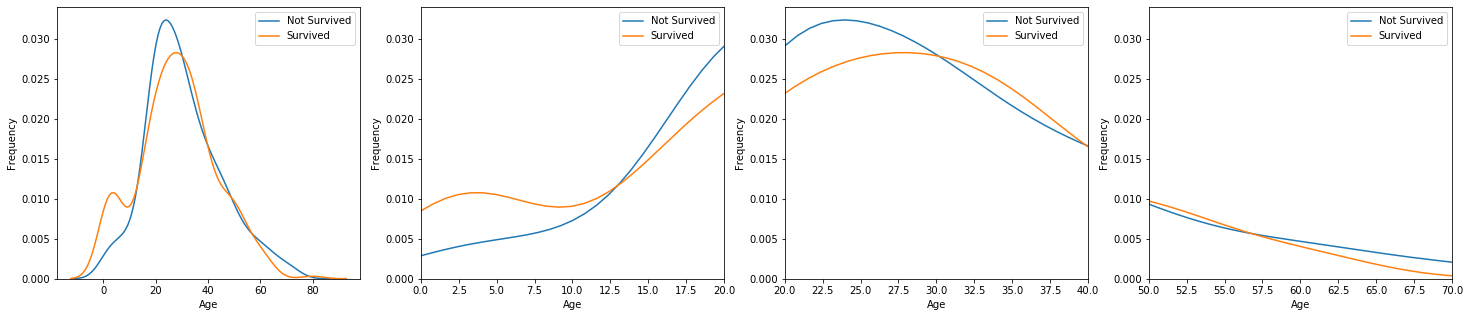

In [48]:
fig, ax = plt.subplots(1, 4, figsize=(25, 5))

sns.kdeplot(fd["Age"][(fd["Survived"] == 0) & (fd["Age"].notnull())], ax=ax[0])
sns.kdeplot(fd["Age"][(fd["Survived"] == 1) & (fd["Age"].notnull())], ax=ax[0])
ax[0].set_xlabel("Age")
ax[0].set_ylabel("Frequency")
ax[0] = ax[0].legend(["Not Survived", "Survived"])

sns.kdeplot(fd["Age"][(fd["Survived"] == 0) & (fd["Age"].notnull())], ax=ax[1])
sns.kdeplot(fd["Age"][(fd["Survived"] == 1) & (fd["Age"].notnull())], ax=ax[1])
ax[1].set_xlabel("Age")
ax[1].set_ylabel("Frequency")
ax[1].set(xlim=(0, 20))
ax[1] = ax[1].legend(["Not Survived", "Survived"])

sns.kdeplot(fd["Age"][(fd["Survived"] == 0) & (fd["Age"].notnull())], ax=ax[2])
sns.kdeplot(fd["Age"][(fd["Survived"] == 1) & (fd["Age"].notnull())], ax=ax[2])
ax[2].set_xlabel("Age")
ax[2].set_ylabel("Frequency")
ax[2].set(xlim=(20, 40))
ax[2] = ax[2].legend(["Not Survived", "Survived"])

sns.kdeplot(fd["Age"][(fd["Survived"] == 0) & (fd["Age"].notnull())], ax=ax[3])
sns.kdeplot(fd["Age"][(fd["Survived"] == 1) & (fd["Age"].notnull())], ax=ax[3])
ax[3].set_xlabel("Age")
ax[3].set_ylabel("Frequency")
ax[3].set(xlim=(50, 70))
ax[3] = ax[3].legend(["Not Survived", "Survived"])

### 5.2. Fare Bins Determination
The same process as age bins was achieved with fare bin determination. One distinct feature was the rate of survival of lower paying fare members seems significantly higher than those paying more.

As for Fare, it's observed at approximately 17 years showed relatively significant changes in survival vs. not survived rates.

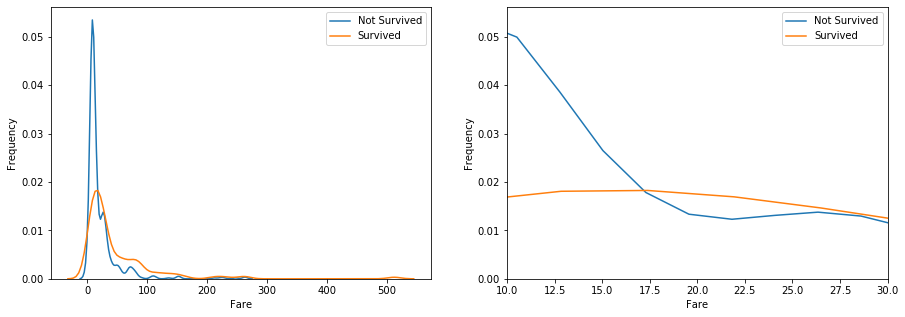

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(fd["Fare"][(fd["Survived"] == 0) &
                       (fd["Fare"].notnull())], ax=ax[0])
sns.kdeplot(fd["Fare"][(fd["Survived"] == 1) &
                       (fd["Fare"].notnull())], ax=ax[0])
ax[0].set_xlabel("Fare")
ax[0].set_ylabel("Frequency")
ax[0] = ax[0].legend(["Not Survived", "Survived"])

sns.kdeplot(fd["Fare"][(fd["Survived"] == 0) &
                       (fd["Fare"].notnull())], ax=ax[1])
sns.kdeplot(fd["Fare"][(fd["Survived"] == 1) &
                       (fd["Fare"].notnull())], ax=ax[1])
ax[1].set_xlabel("Fare")
ax[1].set_ylabel("Frequency")
ax[1].set(xlim=(10, 30))
ax[1] = ax[1].legend(["Not Survived", "Survived"])

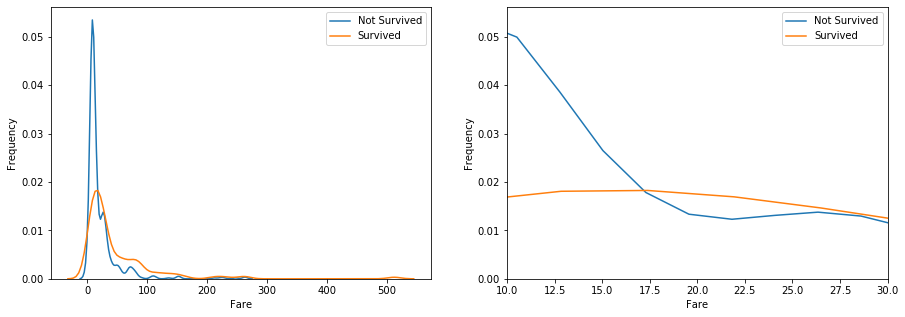

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(fd["Fare"][(fd["Survived"] == 0) &
                       (fd["Fare"].notnull())], ax=ax[0])
sns.kdeplot(fd["Fare"][(fd["Survived"] == 1) &
                       (fd["Fare"].notnull())], ax=ax[0])
ax[0].set_xlabel("Fare")
ax[0].set_ylabel("Frequency")
ax[0] = ax[0].legend(["Not Survived", "Survived"])

sns.kdeplot(fd["Fare"][(fd["Survived"] == 0) &
                       (fd["Fare"].notnull())], ax=ax[1])
sns.kdeplot(fd["Fare"][(fd["Survived"] == 1) &
                       (fd["Fare"].notnull())], ax=ax[1])
ax[1].set_xlabel("Fare")
ax[1].set_ylabel("Frequency")
ax[1].set(xlim=(10, 30))
ax[1] = ax[1].legend(["Not Survived", "Survived"])

### 5.3. Bin Function Testing
Overall the binning held the same trends observed with the fare and age when determining binning of each age and fare group. Therefore, most of the information was preserved.

In [51]:
def fare_age_bins(df):
    df['Fare'] = df['Fare'].map(lambda y: "Low" if y < 17 else "High")
    df['Age'] = df['Age'].map(lambda y: "Child" if y < 13
                              else "Early" if y < 30
                              else "Mid" if y < 58
                              else "Late")
    return df

In [52]:
bin_test = missing_pipeline_test.copy()
bin_test.sort_values(by=['Age'], ascending=True, inplace=True)
fare_age_bins(bin_test)

print("Fare :", bin_test.Fare.unique())
print("Age  :", bin_test.Age.unique())
bin_test.describe(include='all')

Fare : ['High' 'Low']
Age  : ['Child' 'Early' 'Mid' 'Late']


,Age,Embarked,Fare,Pclass,Sex,Survived,Ticket,train,Related,Title,Deck,Age_was_missing,Embarked_was_missing,Fare_was_missing,Ticket_was_missing,Deck_was_missing
count,1309,1309,1309,1309.000000,1309,891.000000,1309,1309.000000,1309,1309,1309,1309,1309,1309,1309,1309
unique,4,3,2,NaN,2,NaN,4,NaN,5,4,3,2,2,2,2,2
top,Early,S,Low,NaN,male,NaN,Na,NaN,Solo,M,Na,False,False,False,True,True
freq,661,916,732,NaN,843,NaN,957,NaN,790,766,1014,1046,1307,1308,957,1014
mean,NaN,NaN,NaN,2.294882,NaN,0.383838,NaN,0.680672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,0.837836,NaN,0.486592,NaN,0.466394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,1.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,2.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,3.000000,NaN,0.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,3.000000,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
pd.crosstab(bin_test['Fare'], bin_test['Survived'])

Survived,0.0,1.0
Fare,,
High,185,210
Low,364,132


In [54]:
pd.crosstab(bin_test['Age'], bin_test['Survived'])

Survived,0.0,1.0
Age,,
Child,31,42
Early,296,144
Late,23,10
Mid,199,146


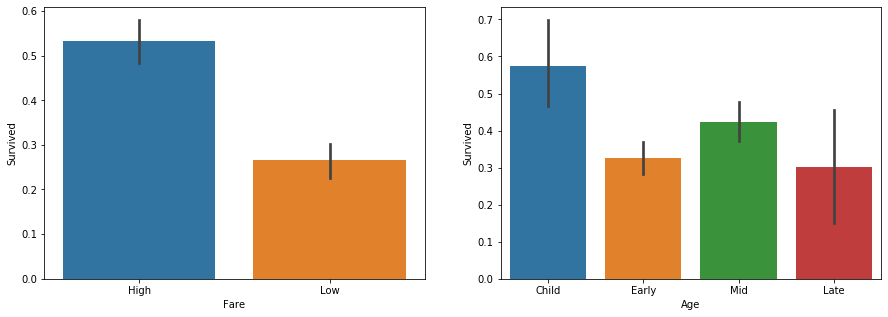

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.catplot(y="Survived", x="Fare", data=bin_test, kind="bar", ax=ax[0])
sns.catplot(y="Survived", x="Age", data=bin_test, kind="bar", ax=ax[1])
for i in range(2, 4):
    plt.close(i)

In [56]:
bin_sort = pd.DataFrame.sort_index(bin_test.copy())
bin_sort.head()

,Age,Embarked,Fare,Pclass,Sex,Survived,Ticket,train,Related,Title,Deck,Age_was_missing,Embarked_was_missing,Fare_was_missing,Ticket_was_missing,Deck_was_missing
PassengerId,,,,,,,,,,,,,,,,
1,Early,S,Low,3.0,male,0.0,Low,1.0,Duo,M,Na,False,False,False,False,True
2,Mid,C,High,1.0,female,1.0,High,1.0,Duo,MF,Less,False,False,False,False,False
3,Early,S,Low,3.0,female,1.0,Mid,1.0,Solo,NF,Na,False,False,False,False,True
4,Mid,S,High,1.0,female,1.0,Na,1.0,Duo,MF,Less,False,False,False,True,False
5,Mid,S,Low,3.0,male,0.0,Na,1.0,Solo,M,Na,False,False,False,True,True


## 6. One-Hot Encoding (categorical Data)
All columns have been adjusted and featured engineered throughout. To ensure each variable is ready for use through our models, they must first be converted to numerical values and to assist, One-Hot encoding is used over dropping or label encoding. This is completed for every categorical column and each column produced is correlated with a variable as specified below.

In [57]:
def OHE_cat(df):
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    cat_col = [col for col in df.columns if df[col].dtype == 'object']
    OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(df[cat_col]))
    OH_cols_train.index = df.index
    df = pd.concat([df, OH_cols_train], axis=1)
    df.drop(cat_col, axis=1, inplace=True)
    return df

In [58]:
OHE_test = bin_sort.copy()
OHE_test = OHE_cat(OHE_test)

OHE_test.head()

,Pclass,Survived,train,Age_was_missing,Embarked_was_missing,Fare_was_missing,Ticket_was_missing,Deck_was_missing,0,1,...,17,18,19,20,21,22,23,24,25,26
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,3.0,0.0,1.0,False,False,False,False,True,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,1.0,1.0,False,False,False,False,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,3.0,1.0,1.0,False,False,False,False,True,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,1.0,1.0,False,False,False,True,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5,3.0,0.0,1.0,False,False,False,True,True,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [59]:
OHE_col_name = bin_test.copy()
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
cat_col = [
    col for col in OHE_col_name.columns if OHE_col_name[col].dtype == 'object']
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(OHE_col_name[cat_col]))

In [60]:
OHEcol = OH_encoder.get_feature_names(cat_col)
OHEcols = pd.DataFrame()
OHEcols['Features'] = OHEcol

OHEcols

,Features
0,Age_Child
1,Age_Early
2,Age_Late
3,Age_Mid
4,Embarked_C
5,Embarked_Q
6,Embarked_S
7,Fare_High
8,Fare_Low
9,Sex_female


## 7. Preprocessing Pipeline Summary
Throughout the process so far, each feature has been cleaned to a level appropriate to be read into a model. This included defining multiple functions to preprocess the raw data in a simple pipeline. The following functions are used and defined below for the final preprocessing pipeline.

1. Feature Engineering
    - Combining Sibsp and Parch to **Related**
    - Extracting **Title** from Names
    - Extracting **Deck** from Cabins
    - Extracting **Ticket** from Tickets
2. Missing Data
    - Added and populated **"_was_missing"** columns
    - **Simple Imputer** missing data
        - Categorical Data - Mode / Constant
        - Numerical Data - Median / *Estimated Age*
3. Binning
    - Binned **Fare**
    - Binned **Age**
4. One-Hot Encoding
    - **OHE** Categorical data

In [61]:
def pp_pipeline(df):
    df = (df
          .pipe(feature_engineering)
          .pipe(missing_data)
          .pipe(fare_age_bins)
          .pipe(OHE_cat))
    return df

In [62]:
pp_test = fd.copy()
pp_test = pp_pipeline(pp_test)

pp_test.head()

,Pclass,Survived,train,Age_was_missing,Embarked_was_missing,Fare_was_missing,Ticket_was_missing,Deck_was_missing,0,1,...,17,18,19,20,21,22,23,24,25,26
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,3.0,0.0,1.0,False,False,False,False,True,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,1.0,1.0,False,False,False,False,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,3.0,1.0,1.0,False,False,False,False,True,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,1.0,1.0,False,False,False,True,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5,3.0,0.0,1.0,False,False,False,True,True,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## 8. Modeling
### 8.1. Simple Random Forest and Test Train Split
The first model built was a random forest classifier with a single validation step using a standard test train split of the testing data. This produced a simple single untuned output.

In [63]:
titanic_train = pp_test[pp_test['train'] == 1]
titanic_test = pp_test[pp_test['train'] == 0]

titanic_train_final = titanic_train.drop(['train'], axis=1)
titanic_test_final = titanic_test.drop(['train', 'Survived'], axis=1)

y_full = titanic_train_final['Survived']
X_full = titanic_train_final.drop(['Survived'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_full, y_full, test_size=0.25, random_state=0)

In [64]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=1)
random_forest.fit(X_train, y_train)
pred_valid = random_forest.predict(X_valid)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
print("acc_random_forest: ", acc_random_forest)
print("MAE : ", mean_absolute_error(y_valid, pred_valid))

acc_random_forest:  90.72
MAE :  0.22869955156950672


In [65]:
preds_test = random_forest.predict(titanic_test_final).astype(int)
output = pd.DataFrame(
    {'PassengerId': titanic_test_final.index, 'Survived': preds_test})
output.to_csv('Simple_RFC_model.csv', index=False)

### 8.2. Cross Validation of Multiple Models
Besides random forest, other models were looked at to determine which ones would be interesting to look at. The following models were compared against each other using a cross validation method with a Kfold of 10 and graphed with the means and standard deviations compared against one another.

In [66]:
import xgboost as xgb

In [67]:
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from xgboost import XGBClassifier

In [68]:
kfold = StratifiedKFold(n_splits=10)
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(
    random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())


cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_full,
                                      y=y_full, scoring="accuracy", cv=kfold, n_jobs=4))
cv_results.append(cross_val_score(XGBClassifier(
    random_state=random_state), X_full, y=y_full, cv=kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans": cv_means, "CrossValerrors": cv_std, "Algorithm": [
                      "SVC", "DecisionTree", "AdaBoost", "RandomForest", "ExtraTrees", "GradientBoosting", "MultipleLayerPerceptron", "KNeighboors", "LogisticRegression", "LinearDiscriminantAnalysis", "XGB Regressor"]})

C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


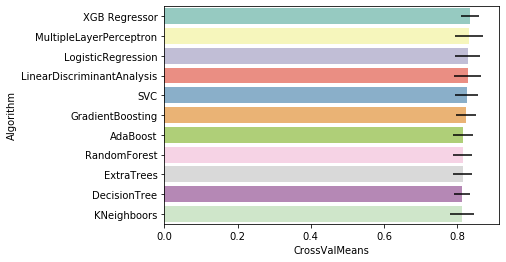

In [69]:
cv_res.sort_values(by=['CrossValMeans'], ascending=False, inplace=True)

g = sns.barplot("CrossValMeans", "Algorithm", data=cv_res,
                palette="Set3", orient="h", **{'xerr': cv_std})

In [70]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
10,0.835103,0.032210,XGB Regressor
6,0.832880,0.026042,MultipleLayerPerceptron
8,0.829460,0.025139,LogisticRegression
9,0.828286,0.021880,LinearDiscriminantAnalysis
0,0.826014,0.024834,SVC
5,0.825015,0.027349,GradientBoosting
2,0.815989,0.034224,AdaBoost
3,0.814890,0.035912,RandomForest
4,0.814852,0.032037,ExtraTrees
1,0.813704,0.038584,DecisionTree


### 8.3. Hyperparameter Tuning
To support the development of the model, we look to tun the parameters of each model. Six of the eleven were picked for their higher scoring on the cross validation checks above. It's observed that the scores outputted weren't significantly better the default un-tuned scores above, but there should be slight improvement with the adjustments.

#### 8.3.1 Logistic Regression

In [71]:
LR = LogisticRegression()
lr_param_grid = {"penalty": ['l1', 'l2'],
                 "max_iter": [100, 150, 50],
                 "multi_class": ['auto', 'ovr'],
                 "tol": [0.001, 0.01, 0.05]}

gsLR = GridSearchCV(LR, param_grid=lr_param_grid, cv=kfold,
                    scoring="accuracy", n_jobs=4, verbose=1)

gsLR.fit(X_full, y_full)

LR_best = gsLR.best_estimator_

gsLR.best_score_

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    1.2s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.835016835016835

In [72]:
LR_best

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.05, verbose=0,
                   warm_start=False)

#### 8.3.2. RandomForestClassifier

In [73]:
RFC = RandomForestClassifier()
rfc_param_grid = {'n_estimators': [400, 300, 200],
                  'min_samples_split': [12, 13],
                  'min_samples_leaf': [1, 2]}

gsRFC = GridSearchCV(RFC, param_grid=rfc_param_grid, cv=kfold,
                     scoring="accuracy", n_jobs=4, verbose=1)

gsRFC.fit(X_full, y_full)

RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   12.6s finished


0.8395061728395061

In [74]:
RFC_best

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=13,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### 8.3.3. Linear Discriminant Analysis

In [75]:
LDA = LinearDiscriminantAnalysis()
lda_param_grid = {"solver": ['svd', 'lsqr'],
                  "n_components": [1, 2, 3],
                  "tol": [0.01, 0.005, 0.05]}

gsLDA = GridSearchCV(LDA, param_grid=lda_param_grid, cv=kfold,
                     scoring="accuracy", n_jobs=4, verbose=1)

gsLDA.fit(X_full, y_full)

LDA_best = gsLDA.best_estimator_

gsLDA.best_score_

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    1.0s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.8282828282828283

In [76]:
LDA_best

LinearDiscriminantAnalysis(n_components=1, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.01)

#### 8.3.4. XG Boost

In [77]:
XGBC = XGBClassifier()
xgb_param_grid = {"learning_rate": [0.30],
                  "max_depth": [9, 10, 11],
                  "min_child_weight": [7, 6, 5],
                  "gamma": [0.1],
                  "colsample_bytree": [1],
                  "n_estimators": [200, 150, 250]}

gsXGB = GridSearchCV(XGBC, param_grid=xgb_param_grid,
                     cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsXGB.fit(X_full, y_full)

XGB_best = gsXGB.best_estimator_

gsXGB.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   43.5s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:  1.0min finished


0.835016835016835

In [78]:
XGB_best

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.3, max_delta_step=0, max_depth=10,
              min_child_weight=6, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

#### 8.3.5. Support Vector Machines

In [79]:
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'],
                  'gamma': [0.005, 0.01, 0.05],
                  'C': [75, 85, 100, 125]}

gsSVMC = GridSearchCV(SVMC, param_grid=svc_param_grid,
                      cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsSVMC.fit(X_full, y_full)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    6.7s finished


0.8316498316498316

In [80]:
SVMC_best

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

#### 8.3.6. Summary of Best Scores

In [81]:
best_score = [gsSVMC.best_score_, gsXGB.best_score_,
              gsLDA.best_score_, gsRFC.best_score_, gsLR.best_score_]
models = ['SVM', 'XGB', 'LDA', 'RFC', 'LR']
HT_scores = pd.DataFrame({"Scores": best_score, "Algorithm": models})
HT_scores.sort_values(by=['Scores'], ascending=False, inplace=True)

HT_scores

,Scores,Algorithm
3,0.839506,RFC
1,0.835017,XGB
4,0.835017,LR
0,0.831650,SVM
2,0.828283,LDA


### 8.4. Feature Selection Testing
Feature selection is used for tree-based models and therefore can be applied to the XGB and RFC models tested prior. The feature importance shows which columns more heavily influence the final predictions and therefore can be important to predicting which values are indicators of survival.

#### 8.4.1. XGB Feature Selection
The reduced dataframes show a total of 4 columns which correlate to the top nine feature importance. These include: **Title_M, Related_Large, Pclass, Deck_was_missing**.

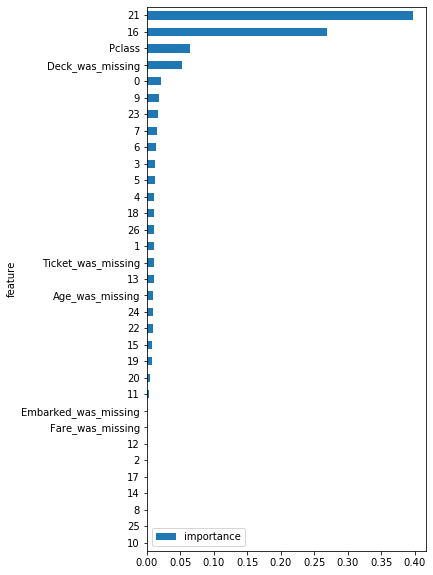

In [82]:
features = pd.DataFrame()
features['feature'] = X_full.columns
features['importance'] = XGB_best.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(5, 10))

In [83]:
XGB_reduced = SelectFromModel(XGB_best, prefit=True)
XGB_train_reduced = XGB_reduced.transform(X_full)
print(XGB_train_reduced.shape)

(891, 4)


In [84]:
XGB_test_reduced = XGB_reduced.transform(titanic_test_final)
print(XGB_test_reduced.shape)

(418, 4)


#### 8.4.2. RFC Feature Selection
The reduced dataframes show a total of 9 columns which correlate to the top nine feature importance. These include: **Sex_male, Title_M, Sex_female, Pclass, Related_Large, Title_MF, Title_NF, Deck_Na, Deck_was_missing**.

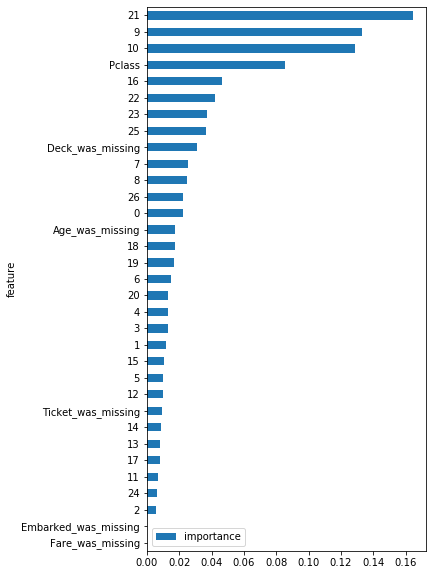

In [96]:
features = pd.DataFrame()
features['feature'] = X_full.columns
features['importance'] = RFC_best.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(5, 10))

In [86]:
RFC_reduced = SelectFromModel(RFC_best, prefit=True)
RFC_train_reduced = RFC_reduced.transform(X_full)
print(RFC_train_reduced.shape)

(891, 9)


In [87]:
RFC_test_reduced = RFC_reduced.transform(titanic_test_final)
print(RFC_test_reduced.shape)

(418, 9)


### 8.4. Final Submission
The final outputs are show below with the first showing all the models with their best parameters compiled through a soft voting classifier which combines each model's outputs to determine the most accurate representation of the final score. The rest are single model outputs used to compare results.

#### 8.4.1. Ensemble Model Output

In [88]:
votingC = VotingClassifier(estimators=[(
    'svc', SVMC_best), ('XGBfit', XGB_best), ('RFC', RFC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_full, y_full)

In [89]:
test_Survived = pd.Series(votingC.predict(
    titanic_test_final).astype(int), name="Survived")

results = pd.DataFrame(
    {'PassengerId': titanic_test_final.index, 'Survived': test_Survived})

results.to_csv("Titanic_Submission_AC.csv", index=False)

#### 8.4.2. Reduce Features Outputs

In [90]:
RFCfit = RFC_best.fit(RFC_train_reduced, y_full)

test_Survived = pd.Series(RFCfit.predict(
    RFC_test_reduced).astype(int), name="Survived")

results = pd.DataFrame(
    {'PassengerId': titanic_test_final.index, 'Survived': test_Survived})

# results.to_csv("Titanic_RFC_Reduced.csv",index=False)

In [91]:
XGBfit = XGB_best.fit(XGB_train_reduced, y_full)

test_Survived = pd.Series(XGBfit.predict(
    XGB_test_reduced).astype(int), name="Survived")

results = pd.DataFrame(
    {'PassengerId': titanic_test_final.index, 'Survived': test_Survived})

# results.to_csv("Titanic_XGB_Reduced.csv",index=False)

#### 8.4.3. Hyperparameter Tuned Models Outputs

In [92]:
LRfit = LR_best.fit(X_full, y_full)

test_Survived = pd.Series(LRfit.predict(
    titanic_test_final).astype(int), name="Survived")

results = pd.DataFrame(
    {'PassengerId': titanic_test_final.index, 'Survived': test_Survived})

# results.to_csv("Titanic_LR.csv",index=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [93]:
LDAfit = LDA_best.fit(X_full, y_full)

test_Survived = pd.Series(LDAfit.predict(
    titanic_test_final).astype(int), name="Survived")

results = pd.DataFrame(
    {'PassengerId': titanic_test_final.index, 'Survived': test_Survived})

# results.to_csv("Titanic_LDA.csv",index=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [94]:
XGBfit = XGB_best.fit(X_full, y_full)

test_Survived = pd.Series(XGBfit.predict(
    titanic_test_final).astype(int), name="Survived")

results = pd.DataFrame(
    {'PassengerId': titanic_test_final.index, 'Survived': test_Survived})

# results.to_csv("Titanic_XGB.csv",index=False)

In [95]:
RFCfit = RFC_best.fit(X_full, y_full)

test_Survived = pd.Series(RFCfit.predict(
    titanic_test_final).astype(int), name="Survived")

results = pd.DataFrame(
    {'PassengerId': titanic_test_final.index, 'Survived': test_Survived})

# results.to_csv("Titanic_RFC.csv",index=False)

# References

###### "Ace the Titanic Kaggle Challenge" (@ahmedbesbes)**
    https://github.com/ahmedbesbes/gatsby-blog/blob/master/content/blog/1-ace-the-titanic-kaggle-challenge/index.md
###### "Titanic Top 4% with ensemble modeling" (@yassineghouzam)
    https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
###### "Titanic Data Science Solutions" (@Manav Sehgal)
    https://www.kaggle.com/startupsci/titanic-data-science-solutions
